# Recommendation Systems with TensorFlow

**Code** [Copyright 2018 Google LLC](https://developers.google.com/machine-learning/recommendation/)

**Data** [Movielens](https://movielens.org/)

필요한 패키지를 import 합니다

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Pandas DataFrame에 편의 기능 추가
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Altair 설치, 코랩 렌더러 활성화
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# spreadsheets 설치 인증 모듈 불러오기
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-myiy37bm
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-myiy37bm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-cp36-none-any.whl size=730117 sha256=f8259c8dce68c9ef22ccdf0da9e9ced8d9e547fbe6c28f5e3a9029d718e66cbe
  Stored in directory: /tmp/pip-ephem-wheel-cache-6l0sv3pd/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair
Done installing Altair.


Movielens 데이터를 다운로드하고 DataFrame을 만듭니다

In [ ]:
# Movielens 데이터 다운로드
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# 사용자, 영화, 평점 데이터셋 불러오기
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# 영화 파일에 장르에 관한 정보 불러오기
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# id가 1에서 시작하므로 0으로 시작하도록 이동
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# 장르가 할당 된 영화 수를 계산
genre_occurences = movies[genre_cols].sum().to_dict()

# 영화가 여러 장르를 가질 수 있으므로 장르는 다음과 같은 규칙을 따른다
# - all_genres: 영화의 모든 장르
# - genre: 장르 중 하나를 무작위 추출
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# 모든 movielens 데이터를 포함하는 하나의 DataFrame을 만듭니다
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# 데이터를 훈련 세트, 테스트 세트로 분할합니다
def split_dataframe(df, holdout_fraction=0.1):
  """
  Args:
    df: 데이터프레임
    holdout_fraction: 테스트 세트에서 사용할 데이터프레임의 비율
  Returns:
    train: 훈련을 위한 데이터프레임
    test: 테스트를 위한 데이터프레임
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


# I. Exploring the Movielens Data
모델 구축 전 Movielens 데이터 세트의 통계를 살펴보고 이해합니다

### Users

In [ ]:
users.describe(include=[np.object])

user_id  sex occupation zip_code
count      943  943        943      943
unique     943    2         21      795
top          5    M    student    55414
freq         1  670        196        9

In [ ]:
# Altair를 이용한 차트 그리기

# 사용자 데이터를 분할하는 직업 필터 만들기
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# 히스토그램 생성하기
def filtered_hist(field, label, filter):
  """첫 번째 레이어(연한 회색)에는 전체 데이터의 히스토그램
     두 번째 레이어에는 필터링된 데이터의 히스토그램
  Args:
    field: 히스토그램을 생성할 필드
    label: 히스토그램의 문자열 레이블
    filter: 데이터를 분할하는 필터 (alt.Selection 객체)
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

직업에 따른 사용자 별 등급 분포 (Shift키를 눌러 여러개 선택 가능)

In [ ]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

# 개수에 대한 차트와 평균에 대한 차트
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings)

alt.HConcatChart(...)

### Movies

In [ ]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [ ]:
# 리뷰 수가 많은 영화 10가지
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

title  rating count  rating mean
49                Star Wars (1977)           583        4.358
257                 Contact (1997)           509        3.804
99                    Fargo (1996)           508        4.156
180      Return of the Jedi (1983)           507        4.008
293               Liar Liar (1997)           485        3.157
285    English Patient, The (1996)           481        3.657
287                  Scream (1996)           478        3.441
0                 Toy Story (1995)           452        3.878
299           Air Force One (1997)           431        3.631
120  Independence Day (ID4) (1996)           429        3.438

In [ ]:
# 평점 평균이 높은 영화 10가지
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

title  ...  rating mean
407                              Close Shave, A (1995)  ...        4.491
317                            Schindler's List (1993)  ...        4.466
168                         Wrong Trousers, The (1993)  ...        4.466
482                                  Casablanca (1942)  ...        4.457
113  Wallace & Gromit: The Best of Aardman Animatio...  ...        4.448
63                    Shawshank Redemption, The (1994)  ...        4.445
602                                 Rear Window (1954)  ...        4.388
11                          Usual Suspects, The (1995)  ...        4.386
49                                    Star Wars (1977)  ...        4.358
177                                12 Angry Men (1957)  ...        4.344

[10 rows x 3 columns]

In [ ]:
# 평점과 평균 등급의 분포
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

alt.HConcatChart(...)

# II. Preliminaries

평점 행렬 $A$ 를 사용자 임베딩 행렬 $U$ 와 영화 임베딩 행렬 $V$ 의 곱으로 분해하여 

 $A \approx UV^\top$ 를
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ 와
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$ 로 표현하고자 한다

- $N$ 은 사용자 수,
- $M$ 은 영화 개수,
- $A_{ij}$ 는 $j$th 번째 영화의 $i$th 사용자 평점,
- $U_i$ 행은 사용자 $i$ 의 $d$-차원 벡터 (embedding),
- $V_j$ 행은 영화 $j$ 의 $d$-차원 벡터 (embedding),
- $(i, j)$ 쌍에 대한 평점 예측은 내적 $\langle U_i, V_j \rangle$.

## Sparse Representation of the Rating Matrix

평점 행렬은 매우 크지만 일반적으로 특정 사용자가 몇 개의 영화에 대해서만 평가하기 때문에 대부분의 항목이 관찰되지 않는다.
효율적인 표현을 위해서 [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor)를 사용한다.
`SparseTensor` 는 3개의 텐서를 사용하여 행렬을 나타낸다. `tf.SparseTensor(indices, values, dense_shape)` $A_{ij} = a$ 는 `indices[k] = [i, j]` 와 `values[k] = a` 를 사용하여 인코딩 된다. `dense_shape` 는 전체 기본 행렬의 모양을 지정하는 데에 사용된다.

#### Toy example
두 명의 사용자와 4가지 영화가 있다고 하자.

user\_id | movie\_id | rating
--:|--:|--:
0 | 0 | 5.0
0 | 1 | 3.0
1 | 3 | 1.0

해당하는 평점 행렬은 다음과 같다.

$$
A =
\begin{bmatrix}
5.0 & 3.0 & 0 & 0 \\
0   &   0 & 0 & 1.0
\end{bmatrix}
$$

SparseTensor 표현은 다음과 같다.
```python
SparseTensor(
  indices=[[0, 0], [0, 1], [1,3]],
  values=[5.0, 3.0, 1.0],
  dense_shape=[2, 4])
```

### Exercise 1: 평점 행렬의 tf.SparseTensor 표현 작성하기

`ratings` 데이터프레임을 `tf.SparseTensor` 로 매핑해봅니다.

Hint: `df['column_name'].values` 를 사용하여 `df` 의 특정 열 값을 선택할 수 있습니다.

In [ ]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: `user_id`, `movie_id`, `rating` 열이 있는 pd.DataFrame
  Returns:
    평점 행렬을 나타내는 tf.SparseTensor
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values

  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

## Calculating the error

MSE를 사용하여 예측값과 관측값의 차이 (오차)를 계산한다.

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
여기서 $\Omega$ 는 관찰된 평점 집합이고 $|\Omega|$ 는 $\Omega$ 의 카디널리티(unique한 값의 개수)이다.


Note:

 전체 예측 행렬 $UV^\top$ 을 계산하여 실제 평점과 일치하는 항목을 수집하는 방법이 있다. 이 때 메모리 비용은 $ O (NM) $ 이다. Movielens 데이터의 경우 크기가 충분히 작기 때문에 위의 방법을 사용해도 괜찮다.

 다른 접근법으로 관찰된 쌍의 임베딩만 수집하여 내적을 계산하는 것이다. 이 때 메모리 비용은 $O(|\Omega| d)$ 이다. ($ d $ 는 임베딩 차원) 위 방법과 메모리 비용은 비슷하지만 사용자나 영화의 수가 훨씬 많으면 전자의 방법이 불리하다.

### Exercise 2: Mean Squared Error

$\text{MSE}(A, UV^\top)$를 반환하는 Tensorflow 함수를 작성합니다

Hints:
  * 관찰된 항목에 대해서만 손실을 계산합니다
  * [`tf.gather_nd`](https://www.tensorflow.org/api_docs/python/tf/gather_nd)
  * [`tf.losses.mean_squared_error`](https://www.tensorflow.org/api_docs/python/tf/losses/mean_squared_error)

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: dense_shape [N, M]의 SparseTensor 평점 행렬
    user_embeddings: k가 embedding dimension인 dense Tensor U [N, k]
    movie_embeddings: k가 embedding dimension인 dense Tensor V [M, k]
  Returns:
    실제 평점과 예측 평점 사이의 MSE를 나타내는 스칼라
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

# III. Training a Matrix Factorization model

## CFModel (Collaborative Filtering Model) helper class
SGD(stochastic gradient descent)를 사용하여 행렬 분해 모델을 훈련하는 클래스이다.

클래스 생성자는 다음과 같다.
- 사용자 임베딩 U (a `tf.Variable`).
- 영화 임베딩 V, (a `tf.Variable`).
- 최적화 할 손실 (a `tf.Tensor`).
- 딕셔너리의 옵션 리스트, 훈련 중에 평가되고 그림으로 보여진다.

트레이닝이 끝나면 `model.embeddings` 딕셔너리를 이용하여 훈련된 임베딩에 접근할 수 있다.

Example usage:
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
movie_embeddings = model.embeddings['movie_id']
```

In [ ]:
class CFModel(object):
  def __init__(self, embedding_vars, loss, metrics=None):
    """CFModel의 Initializing
    Args:
      embedding_vars: tf.Variables 딕셔너리
      loss: 최적화 할 손실
      metrics: 텐서 딕셔너리의 옵션 목록
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """임베딩 딕셔너리"""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """
    Args:
      iterations: 반복 횟수
      learning_rate: 
      plot_results: plotting을 할 것인가
      optimizer: 
    Returns:
      마지막 반복에서 평가된 metric 딕셔너리
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # 결과를 학습시키고 추가한다
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

### Exercise 3: Build a Matrix Factorization model and train it

`sparse_mean_square_error` 함수를 이용하여 `CFModel` 을 만드는 함수를 작성합니다.

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: 평점 데이터프레임
    embedding_dim: 임베딩 벡터의 차원
    init_stddev: float, 랜덤 초기 임베딩의 표준편차
  Returns:
    model: CFModel
  """
  # 평점 데이터프레임을 훈련 세트와 테스트 세트로 분할
  train_ratings, test_ratings = split_dataframe(ratings)
  # 훈련 및 테스트 데이터 세트의 SparseTensor 표현
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # 정규분포를 사용하여 임베딩을 초기화(initialize)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

 iteration 1000: train_error=0.372838, test_error=1.387499

[{'test_error': 1.3874989, 'train_error': 0.37283838}]

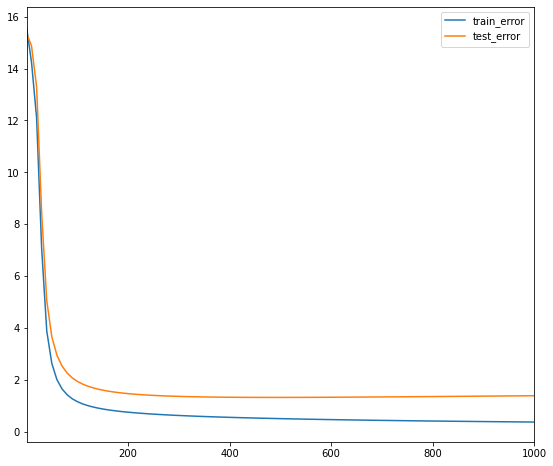

In [ ]:
# CF 모델을 만들고 훈련합니다
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

# IV. Inspecting the Embeddings

학습된 임베딩에 대해 자세히 살펴봅니다.
- 추천 영화 계산하기
- 비슷한 영화 찾아보기
- 영화 임베딩의 norm 살펴보기
- 투영된 임베딩 공간에서 임베딩 시각화

Exercise 4: 영화 후보의 점수를 계산하는 함수 작성

영화 후보의 예측 평점을 계산하기 위하여 유사성을 측정한다. 유사성 측정 방법에 따라 다른 결과가 나올 수 있다. 이를 비교하기 위해 유사성을 측정하는 방법에는 다음 두 가지를 사용한다.

- dot product: 영화 j의 점수를 $\langle u, V_j \rangle$ 로 계산
- cosine: 영화 j의 점수를 $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$ 로 계산

Hints:
- [`np.dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) 를 이용해 두 np.Arrays의 곱을 계산할 수 있다.
- [`np.linalg.norm`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.norm.html) np.Array의 norm을 계산

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """
  Args:
    query_embedding: vector[k]
    item_embeddings: 항목 i에 대한 metrix[N, k]
    measure: 사용할 유사성 측정 값 지정 (DOT or COSINE)
  Returns:
    scores: 항목 i에 대한 평점 vector[N]
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [ ]:
# 평점에 따라 추천하는 시스템 만들기
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # 이미 평가된 영화 제거
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # 주어진 문자열과 일치하는 영화 ID 검색
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
user_recommendations(model, measure=COSINE, k=5)

In [ ]:
movie_neighbors(model, "Aladdin", DOT)
movie_neighbors(model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...                                     genres
94        6.194  ...          Animation-Children-Comedy-Musical
317       5.415  ...                                  Drama-War
495       5.409  ...                                      Drama
1083      5.408  ...                                Documentary
171       5.398  ...  Action-Adventure-Drama-Romance-Sci-Fi-War
49        5.357  ...        Action-Adventure-Romance-Sci-Fi-War

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score                     titles                             genres
94          1.000             Aladdin (1992)  Animation-Children-Comedy-Musical
203         0.850  Back to the Future (1985)                      Comedy-Sci-Fi
193         0.848          Sting, The (1973)                       Comedy-Crime
392         0.829      Mrs. Doubtfire (1993)                             Comedy
163         0.815          Abyss, The (1989)   Action-Adventure-Sci-Fi-Thriller
78          0.813       Fugitive, The (1993)                    Action-Thriller

학습된 임베딩의 성능이 좋지 않다. 다음 섹션에서 소개하는 정규화 기술을 추가해보자.

## Movie Embedding Norm

내적과 코사인 유사도 측정에 따라 추천 내용이 달라지는 것을 관찰할 수 있었다. 내적을 사용하면 모델이 인기 영화를 추천하는 경향이 있다. 이는 행렬 분해 모델에서 임베딩의 norm이 인기(인기 영화의 norm이 더 크다)와 관련이 있는 경우가 많기 때문에 더 인기있는 영화를 추천할 가능성이 높아지는 것이다. 임베딩 표준에 따라 영화를 정렬하면 이 가설을 확인할 수 있다.

In [ ]:
# @title Embedding Visualization code

def movie_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_movie_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["movie_id"])
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')

In [ ]:
movie_embedding_norm(model)

alt.HConcatChart(...)

Note:

모델이 초기화 되는 방식에 따라 일부 평점이 거의 없는 영화의 norm이 높기 때문에 잘못된 추천이 표시될 수 있다. 해당 영화의 임베딩이 높은 norm으로 초기화 되기 때문이다. 영화의 평점이 잘 매겨지지 않아 자주 업데이트 되지 않아 높은 norm을 유지하는 것이다. 이는 정규화를 사용하면 완화될 수 있다.

하이퍼 파라미터 `init_stddev` 의 값을 변경해보자. $d$-차원 벡터 $\sim \mathcal N(0, \sigma^2)$ 의 norm은 $\sigma \sqrt d$ 로 근사된다.

 iteration 1000: train_error=0.357868, test_error=1.000517Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...                                     genres
94       5.791  ...          Animation-Children-Comedy-Musical
171      5.106  ...  Action-Adventure-Drama-Romance-Sci-Fi-War
132      4.956  ...                          Drama-Romance-War
49       4.926  ...        Action-Adventure-Romance-Sci-Fi-War
317      4.838  ...                                  Drama-War
63       4.781  ...                                      Drama

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                             genres
94           1.000  ...  Animation-Children-Comedy-Musical
334          0.837  ...                             Comedy
984          0.837  ...                              Drama
1190         0.830  ...                        Crime-Drama
1189         0.820  ...                     Comedy-Romance
1654         0.819  ...                     Comedy-Romance

[6 rows x 3 columns]

alt.HConcatChart(...)

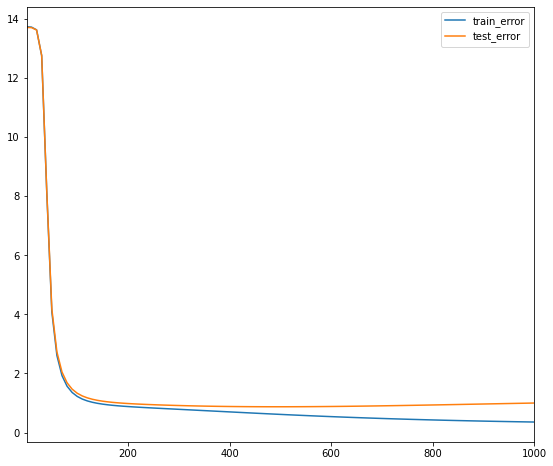

In [ ]:
model_lowinit = build_model(ratings, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
movie_neighbors(model_lowinit, "Aladdin", DOT)
movie_neighbors(model_lowinit, "Aladdin", COSINE)
movie_embedding_norm([model, model_lowinit])

## Embedding visualization
고차원 공간에서 임베딩을 시각화하기가 어렵기 때문에 (임베딩 차원 $k > 3$), 임베딩을 더 낮은 차원 공간에 투영하여 시각화할 수 있다. T-SNE (T-distributed Stochastic Neighbor Embedding)는 거리를 유지하면서 임베딩을 투영하는 알고리즘이다. 시각화에 유용하게 사용되지만 주의해서 사용해야한다. [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/).

In [ ]:
tsne_movie_embeddings(model_lowinit)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.001s...
[t-SNE] Computed neighbors for 1682 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.114988
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.219490
[t-SNE] KL divergence after 400 iterations: 2.252836


alt.HConcatChart(...)

임베딩이 눈에 띄는 구조를 갖지 않는 것처럼 보이며 특정 장르의 임베딩이 임베딩 공간 전체에 위치한다는 것을 알 수 있다. 이는 정규화를 하지 않아 학습 된 임베딩의 품질이 좋지 않기 때문이다.

# V. Regularization In Matrix Factorization

이전 섹션에서 손실은 MSE로 정의되었다. 이는 모델이 관련 없는 영화의 임베딩을 배치하는 방법을 배우지 않았기 때문에 문제가 될 수 있다. 이런 현상을 *folding* 이라고 한다.

이 문제를 해결하기 위해 두 가지 유형의 정규화를 사용한다.
- 모델의 파라미터 정규화. $\ell_2$ 정규화로 알려져있다.

  $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- 모든 쌍의 예측을 0으로 밀어붙이는 방법, *gravity* 로 알려져있다.

  $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

총 손실은 다음과 같다.
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
이 때 $\lambda_r$ 와 $\lambda_g$ 는 정규화 계수이다.(하이퍼 파라미터)

### Exercise 4: 정규화 된 행렬 분해 모델을 만들고 훈련
정규화 된 모델을 만드는 함수를 작성하자. 임베딩 행렬 $U$, $V$ 이 주어지면 `gravity(U, V)` 를 계산하는 함수는 제공된다.

In [ ]:
def gravity(U, V):
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: 평점 데이터프레임
    embedding_dim: 임베딩 공간의 차원
    regularization_coeff: 정규화 계수 lambda
    gravity_coeff: gravity 정규화 계수 lambda_g
  Returns:
    CFModel
  """
  # 데이터프레임을 훈련 세트와 테스트 세트로 분할한다
  train_ratings, test_ratings = split_dataframe(ratings)
  # 훈련 세트와 테스트 세트의 SparseTensor 표현
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "movie_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 2000: train_error_observed=0.998368, test_error_observed=2.514266, observed_loss=0.998368, regularization_loss=0.852021, gravity_loss=1.314587

[{'test_error_observed': 2.5142665, 'train_error_observed': 0.9983679},
 {'gravity_loss': 1.3145868,
  'observed_loss': 0.9983679,
  'regularization_loss': 0.85202134}]

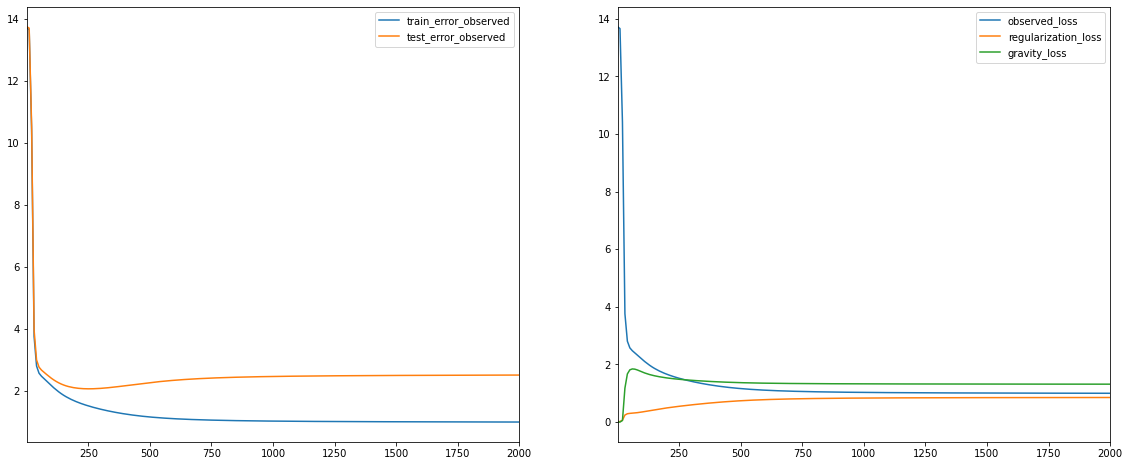

In [ ]:
reg_model = build_regularized_model(
    ratings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

정규화 층을 추가하면 훈련 세트와 테스트 세트 모두 더 높은 MSE가 생성된다. 그러나 추천 시스템의 품질은 향상된다.

### Inspect the results
정규화 하기 전과 후의 결과를 비교하자

In [ ]:
user_recommendations(reg_model, DOT, exclude_rated=True, k=10)

모델이 높은 평가를 받은 항목을 추천할 가능성이 높으므로 `exclude_rated=True` 를 사용하여 평가 한 항목을 제외할 수 있다.

가장 유사한 영화와 임베딩 norm 및 영화 임베딩의 t-SNE 투영을 보자

In [ ]:
movie_neighbors(reg_model, "Aladdin", DOT)
movie_neighbors(reg_model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...                                     genres
94       9.666  ...          Animation-Children-Comedy-Musical
70       8.276  ...                 Animation-Children-Musical
587      7.775  ...                 Animation-Children-Musical
21       7.361  ...                           Action-Drama-War
173      7.149  ...                           Action-Adventure
171      7.123  ...  Action-Adventure-Drama-Romance-Sci-Fi-War

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                             genres
94          1.000  ...  Animation-Children-Comedy-Musical
70          0.877  ...         Animation-Children-Musical
587         0.833  ...         Animation-Children-Musical
417         0.773  ...         Animation-Children-Musical
72          0.724  ...              Action-Comedy-Western
201         0.701  ...                     Comedy-Romance

[6 rows x 3 columns]

여기서 model과 reg_model에 대한 임베딩 norm을 비교한다.

In [ ]:
movie_embedding_norm([model, model_lowinit, reg_model])

alt.HConcatChart(...)

In [ ]:
tsne_movie_embeddings(reg_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.251710
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.196030
[t-SNE] KL divergence after 400 iterations: 1.488158


alt.HConcatChart(...)

비정규화된 경우보다 훨씬 더 많은 구조를 가지고 있음을 관찰할 수 있다.

# VI. Softmax model

특정 사용자가 영화를 평가했는지 여부를 예측하는 간단한 소프트 맥스 모델을 학습합니다.

In [ ]:
rated_movies = (ratings[["user_id", "movie_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_movies.head()

user_id                                           movie_id
0       0  [60, 188, 32, 159, 19, 201, 170, 264, 154, 116...
1       1  [291, 250, 49, 313, 296, 289, 311, 280, 12, 27...
2      10  [110, 557, 731, 226, 424, 739, 722, 37, 724, 1...
3     100  [828, 303, 595, 221, 470, 404, 280, 251, 281, ...
4     101  [767, 822, 69, 514, 523, 321, 624, 160, 447, 4...

- movie_id: 사용자가 평가한 영화 ID 문자열 텐서
- genre: 해당 영화 장르의 문자열 텐서
- year: 출시 연도의 문자열 텐서

In [ ]:
years_dict = {
    movie: year for movie, year in zip(movies["movie_id"], movies["year"])
}
genres_dict = {
    movie: genres.split('-')
    for movie, genres in zip(movies["movie_id"], movies["all_genres"])
}

def make_batch(ratings, batch_size):
  """
  Args:
    ratings: 평점 데이터프레임 예제["movie_id"]는 사용자에 의해 평가된 영화 리스트
    batch_size: 
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  movie = []
  year = []
  genre = []
  label = []
  for movie_ids in ratings["movie_id"].values:
    movie.append(movie_ids)
    genre.append([x for movie_id in movie_ids for x in genres_dict[movie_id]])
    year.append([years_dict[movie_id] for movie_id in movie_ids])
    label.append([int(movie_id) for movie_id in movie_ids])
  features = {
      "movie_id": pad(movie, ""),
      "year": pad(year, ""),
      "genre": pad(genre, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """x의 각 행에서 임의로 추출"""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))

### Loss function
소프트맥스 모델은 입력 특성 $x$ 를 사용자 임베딩에 매핑합니다 $\psi(x) \in \mathbb R^d$. 이 벡터에 영화 임베딩 행렬을 곱합니다 $V \in \mathbb R^{m \times d}$ 그리고 모델의 마지막 아웃풋은 항목의 소프트맥스가 됩니다.
$$
\hat p(x) = \text{softmax}(\psi(x) V^\top).
$$
타겟 레이블 $y$가 주어질 때 이 타켓 레이블의 원-핫 인코딩을 $p = 1_y$ 로 표시하면, 이 때 손실은 $\hat p(x)$ 과 $p$ 의 cross-entropy 입니다.

### Exercise 5: 소프트맥스 모델의 손실함수를 작성하고 훈련하자

사용자 임베딩 $\psi(x)$, 영화 임베딩 $V$, 타겟 레이블 $y$ 을 나타내는 텐서를 취하고 cross-entropy loss를 반환하는 함수를 작성합니다.

Hint: 
[`tf.nn.sparse_softmax_cross_entropy_with_logits`](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits)
`logits`을 input으로 사용합니다. `logits` 은 제품 $\psi(x) V^\top$ 을 나타냅니다.

In [ ]:
def softmax_loss(user_embeddings, movie_embeddings, labels):
  """
  Args:
    user_embeddings: [batch_size, embedding_dim].
    movie_embeddings: [num_movies, embedding_dim].
    labels: [batch_size]
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  movie_emb_dim = movie_embeddings.shape[1].value
  if user_emb_dim != movie_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the movie embedding "
        "dimension % d" % (user_emb_dim, movie_emb_dim))

  logits = tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

In [ ]:
def build_softmax_model(rated_movies, embedding_cols, hidden_dims):
  """Builds a Softmax model for MovieLens.
  Args:
    rated_movies: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A CFModel object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_movies, test_rated_movies = split_dataframe(rated_movies)
  train_batch = make_batch(train_rated_movies, 200)
  test_batch = make_batch(test_rated_movies, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    movie_embeddings = tf.get_variable(
        "input_layer/movie_id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, movie_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, movie_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, movie_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"movie_id": movie_embeddings}
  return CFModel(embeddings, train_loss, metrics)

 iteration 3000: train_loss=5.524789, test_loss=5.656764, test_precision_at_10=0.011992

({'test_loss': 5.656764, 'train_loss': 5.524789},
 {'test_precision_at_10': 0.01199233588803732})

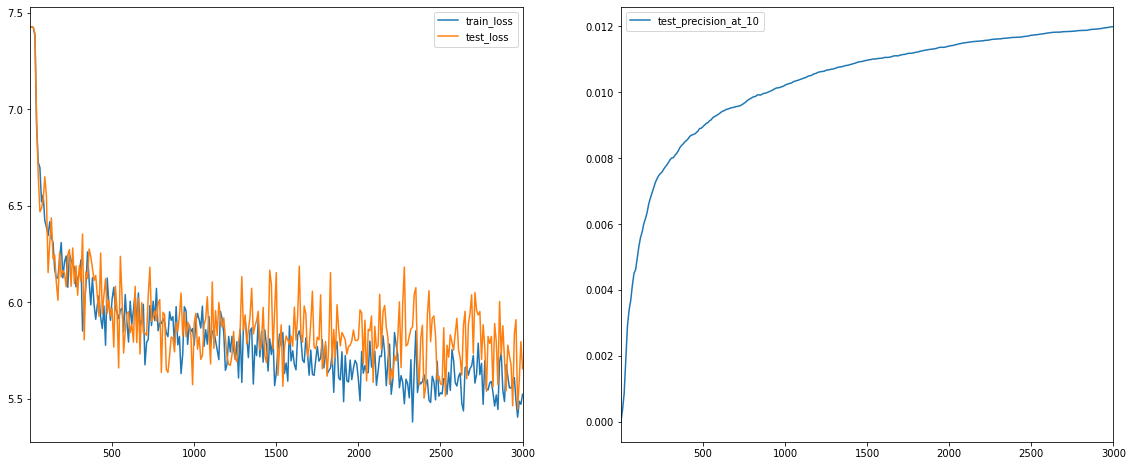

In [ ]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(movies[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')

with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      rated_movies,
      embedding_cols=[
          make_embedding_col("movie_id", 35),
          make_embedding_col("genre", 3),
          make_embedding_col("year", 2),
      ],
      hidden_dims=[35])

softmax_model.train(
    learning_rate=8., num_iterations=3000, optimizer=tf.train.AdagradOptimizer)

In [ ]:
movie_neighbors(softmax_model, "Aladdin", DOT)
movie_neighbors(softmax_model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...                                     genres
27      17.752  ...                      Action-Drama-Thriller
171     17.730  ...  Action-Adventure-Drama-Romance-Sci-Fi-War
203     17.243  ...                              Comedy-Sci-Fi
194     17.015  ...                     Action-Sci-Fi-Thriller
173     17.006  ...                           Action-Adventure
221     16.783  ...                    Action-Adventure-Sci-Fi

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                             genres
94          1.000  ...  Animation-Children-Comedy-Musical
968         0.866  ...                 Animation-Children
70          0.865  ...         Animation-Children-Musical
27          0.857  ...              Action-Drama-Thriller
7           0.822  ...              Children-Comedy-Drama
201         0.802  ...                     Comedy-Romance

[6 rows x 3 columns]

In [ ]:
movie_embedding_norm([reg_model, softmax_model])

alt.HConcatChart(...)

In [ ]:
tsne_movie_embeddings(softmax_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.189930
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.150242
[t-SNE] KL divergence after 400 iterations: 1.235006


alt.HConcatChart(...)

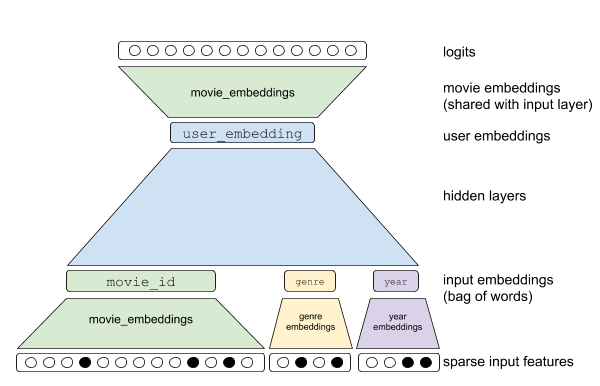

모델의 하이퍼파라미터 조정해보기
- 임베딩 dimension 변경
- 소프트맥스 모델에서 히든 레이어 수 변경
- 다른 유사성 측정 사용